In [8]:
import pandas as pd
import numpy as np
import constants as const
import stellar_spectra as ss
from flatstar import draw
from p_winds import tools, parker, hydrogen, helium, transit, lines
import xsection as xs
import torus as torus
import matplotlib.pyplot as plt

In [2]:
#solar element ratio

solar_abundance = pd.read_excel('SolarSystemAbundances_Lodders2021.xlsx', usecols = [1, 11], names = ['Element', 'Abundance'], skiprows=3, dtype={'Element':'string'}) #in astronomical abundance

#change to abundance relative to hydrogen
solar_abundance['Abundance'] = 10**(solar_abundance['Abundance'] - 12)
sa = dict(zip(solar_abundance['Element'], solar_abundance['Abundance']))
sola =  {k.lower(): v for k, v in sa.items()}

In [3]:
#WASP12 parameters
P = 2 * const.day

WASP12b = {'mass_s': 0.77*const.m_sun, 'radius_s': 0.72*const.r_sun, 
           'mass_p':0.7*const.m_jupiter, 'radius_p':1.4*const.r_jupiter, 'inclination': np.pi/2}

a = (P**2 * const.G * WASP12b['mass_s'] / 4 / np.pi**2)**(1/3)
WASP12b['semimajoraxis']= a
a_div_Rs = WASP12b['semimajoraxis'] / WASP12b['radius_s']
planet_to_star_ratio = WASP12b['radius_p'] / WASP12b['radius_s']
R_pl_physical = WASP12b['radius_p'] / 100

#WASP12b species
WASP12b_species_keys=['h', 'he'] #change what species to include here
WASP12b_species = dict((k, sola[k]) for k in WASP12b_species_keys)

In [17]:
flux_map_oot = draw.star(100, supersampling=10).intensity

flux_map_it, _, _ = transit.draw_transit(
        planet_to_star_ratio,
        planet_physical_radius=R_pl_physical,
        impact_parameter=0,
        phase=0,
        supersampling=10,
        grid_size=100)

parameters = WASP12b

def omega(r):
    return np.sqrt(const.G * parameters['mass_s'] / r**3) 

ap = parameters['semimajoraxis']
cs = 1e6

T = 1.0 * 10**4
#### I want you to change temperature and see how it effects the absorption


#disk centred at planet
Rtorus = [ap - cs / (2 * omega(ap)), ap + cs / (2 * omega(ap))]
solar = ss.stellar_spectra('solar', semi_major_axis=ap/parameters['radius_s'])
solar_spectrum2 = solar.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=10**4.5)
WASP12b_at_ap = torus.Torus(species = WASP12b_species, stellar_spectrum = solar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(1e4), Rtorus=Rtorus, nH=1e8)
i_he3_at_ap, tau_he3_at_ap = WASP12b_at_ap.do_transit('he_1',  ['he_3-0', 'he_3-1', 'he_3-2'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot, indexing='image')
i_tot_he3_at_ap = np.einsum('ij, ijk -> k', flux_map_it, np.exp(-(tau_he3_at_ap)))

0.4110307638930726


Text(0.5, 0, 'wavelength')

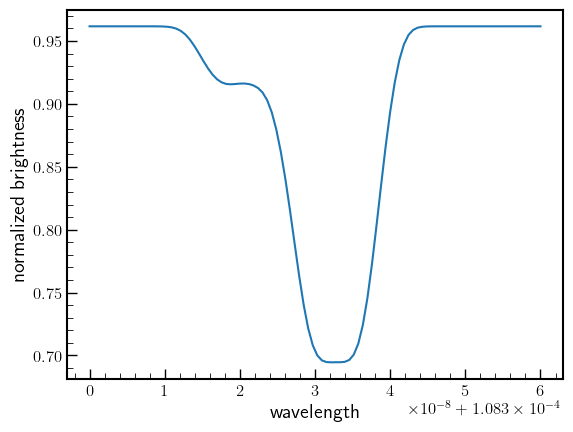

In [18]:
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he3_at_ap)
plt.ylabel('normalized brightness')
plt.xlabel('wavelength')

In [ ]:
#figure out how to calculate the area cut out by the curve and see how that changes as a function of changing the density and temperature